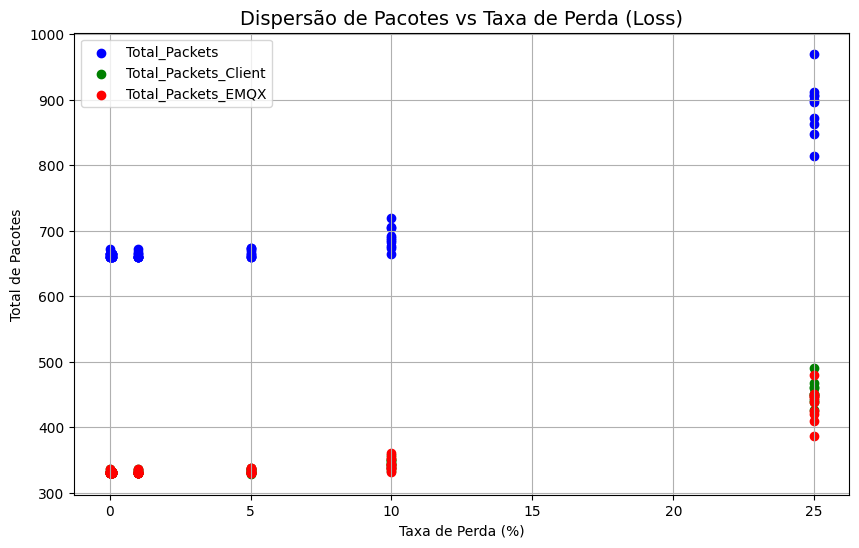

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('quic_analysis.csv')

df['Loss'] = df['Loss'].str.replace('%', '').astype(float)

# Gráfico de Dispersão 
plt.figure(figsize=(10,6))
plt.scatter(df['Loss'], df['Total_Packets'], c='blue', label='Total_Packets')
plt.scatter(df['Loss'], df['Total_Packets_Client'], c='green', label='Total_Packets_Client')
plt.scatter(df['Loss'], df['Total_Packets_EMQX'], c='red', label='Total_Packets_EMQX')
plt.title('Dispersão de Pacotes vs Taxa de Perda (Loss)', fontsize=14)
plt.xlabel('Taxa de Perda (%)')
plt.ylabel('Total de Pacotes')
plt.legend()
plt.grid(True)
plt.show()



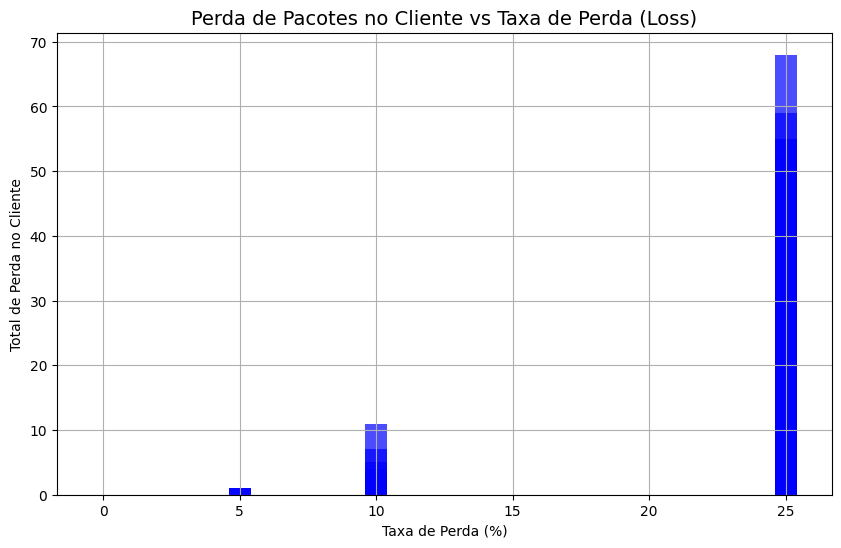

In [5]:
# Gráfico de Barras - Total de Perda de Pacotes no Cliente
plt.figure(figsize=(10,6))
plt.bar(df['Loss'], df['Total_loss_client_emqx'], color='blue', alpha=0.7)
plt.title('Perda de Pacotes no Cliente vs Taxa de Perda (Loss)', fontsize=14)
plt.xlabel('Taxa de Perda (%)')
plt.ylabel('Total de Perda no Cliente')
plt.grid(True)
plt.show()


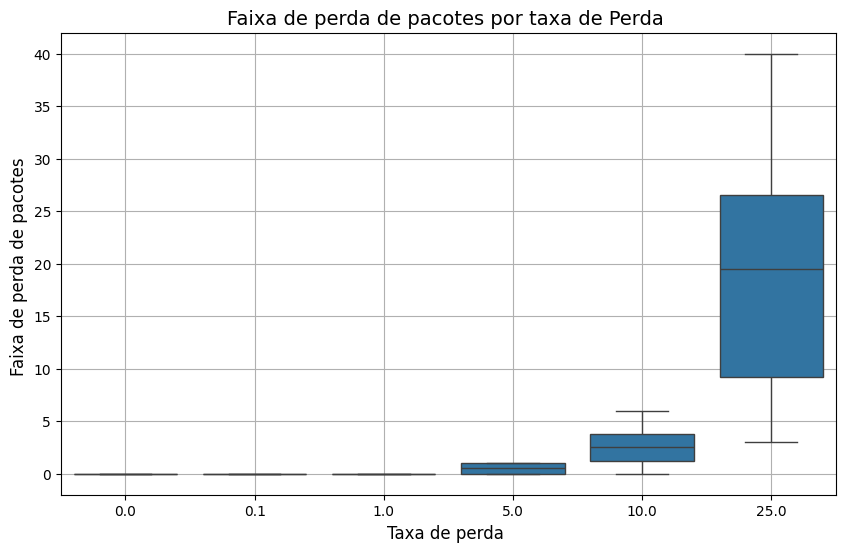

In [6]:
df['Max_Loss'] = df[['Total_loss_client_emqx', 'Total_loss_emqx_client']].max(axis=1)
df['Min_Loss'] = df[['Total_loss_client_emqx', 'Total_loss_emqx_client']].min(axis=1)

df['Loss_Range'] = df['Max_Loss'] - df['Min_Loss']

box_data = pd.melt(df, id_vars=['Loss'], value_vars=['Loss_Range'],
                   var_name='Tipo de Perda', value_name='Faixa de Perda')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Loss', y='Faixa de Perda', data=box_data)

plt.title('Faixa de perda de pacotes por taxa de Perda ', fontsize=14)
plt.xlabel('Taxa de perda ', fontsize=12)
plt.ylabel('Faixa de perda de pacotes ', fontsize=12)

plt.grid(True)

# Exibindo o gráfico
plt.show()

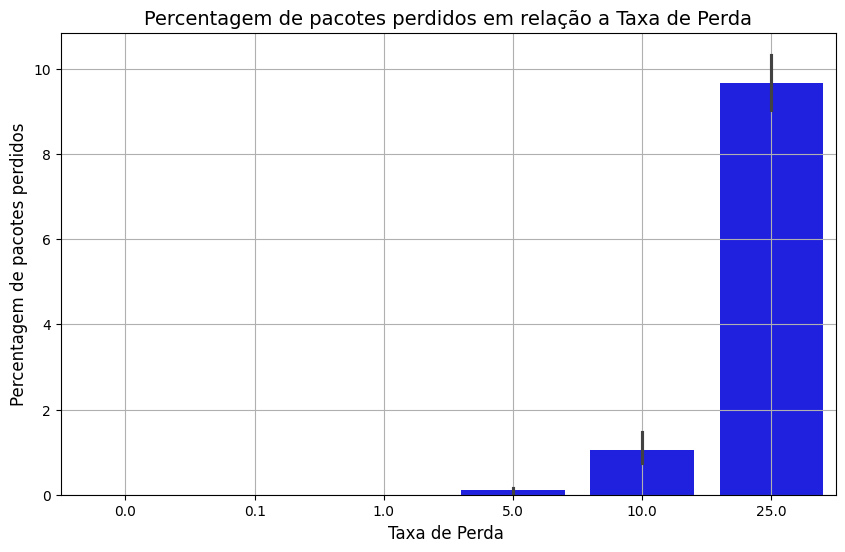

In [7]:
df['Pacotes_Perdidos_Percent'] = (
    (df['Total_loss_emqx_client'] + df['Total_loss_client_emqx']) / df['Total_Packets']) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='Loss', y='Pacotes_Perdidos_Percent', data=df, color='b')

plt.title('Percentagem de pacotes perdidos em relação a Taxa de Perda', fontsize=14)
plt.xlabel('Taxa de Perda ', fontsize=12)
plt.ylabel('Percentagem de pacotes perdidos', fontsize=12)

plt.grid(True)
plt.show()

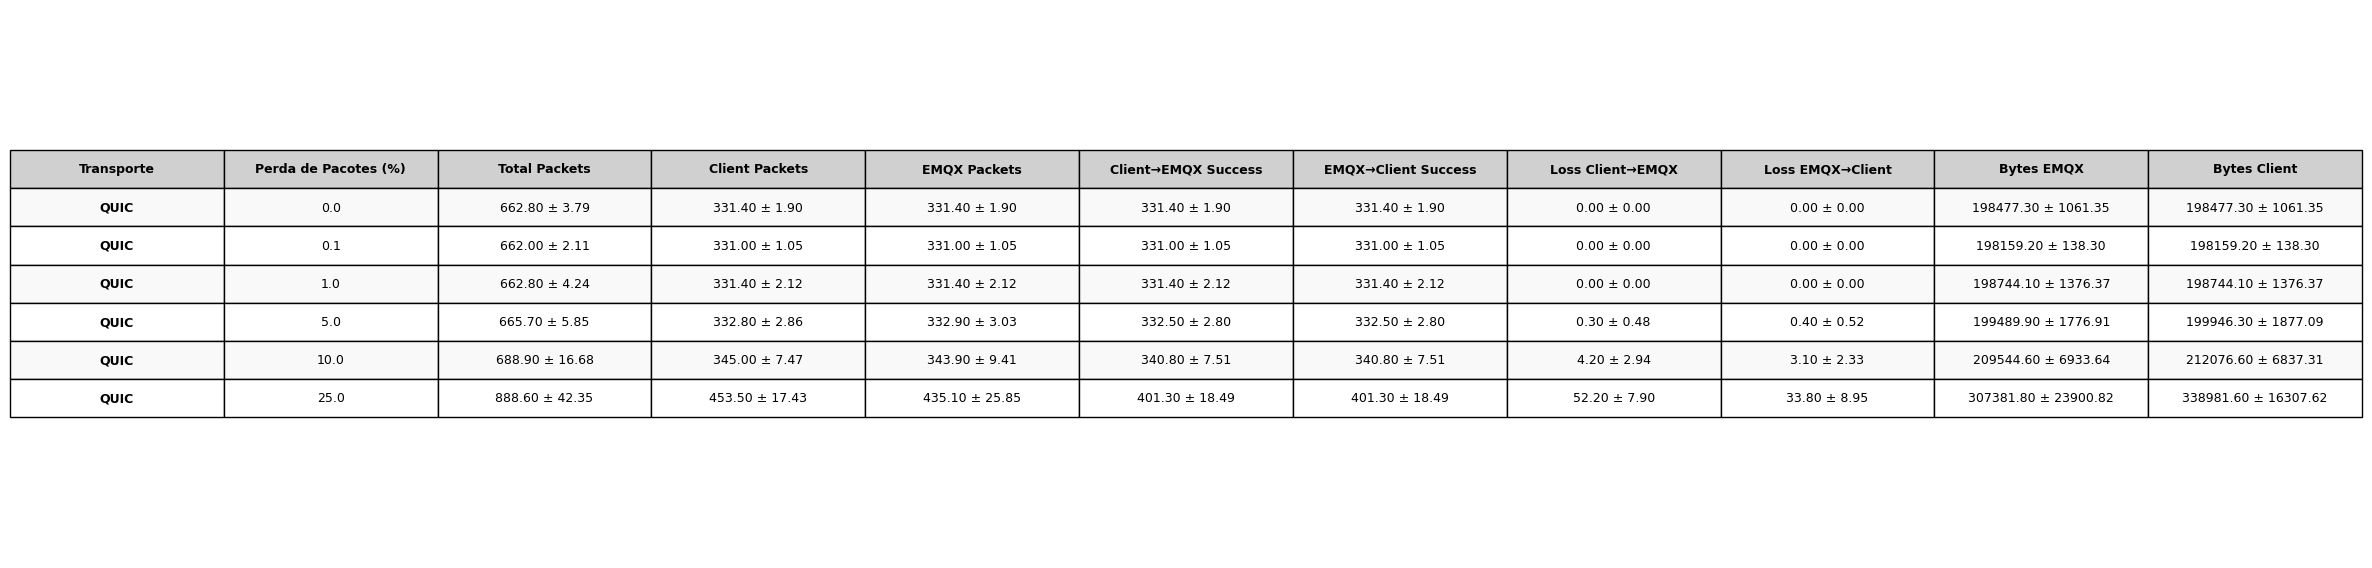

In [10]:
# Leitura do CSV
df = pd.read_csv('quic_analysis.csv')

# Ajusta a coluna 'Loss'
df['Loss'] = df['Loss'].str.replace('%', '').astype(float)

# Adiciona coluna 'transport'
df['transport'] = 'QUIC'

# Agrupa por 'Loss'
grouped = df.groupby(['transport', 'Loss']).agg({
    'Total_Packets': ['mean', 'std'],
    'Total_Packets_Client': ['mean', 'std'],
    'Total_Packets_EMQX': ['mean', 'std'],
    'Total_send_success_client_to_emqx': ['mean', 'std'],
    'Total_send_success_emqx_to_client': ['mean', 'std'],
    'Total_loss_client_emqx': ['mean', 'std'],
    'Total_loss_emqx_client': ['mean', 'std'],
    'Total_bytes_emqx': ['mean', 'std'],
    'Total_bytes_client': ['mean', 'std'],
})

# Formata os dados
formatted_rows = []
for (transport, loss), data in grouped.iterrows():
    formatted_rows.append({
        'Transporte': transport,
        'Perda de Pacotes (%)': loss,
        'Total Packets': f"{data[('Total_Packets', 'mean')]:.2f} ± {data[('Total_Packets', 'std')]:.2f}",
        'Client Packets': f"{data[('Total_Packets_Client', 'mean')]:.2f} ± {data[('Total_Packets_Client', 'std')]:.2f}",
        'EMQX Packets': f"{data[('Total_Packets_EMQX', 'mean')]:.2f} ± {data[('Total_Packets_EMQX', 'std')]:.2f}",
        'Client→EMQX Success': f"{data[('Total_send_success_client_to_emqx', 'mean')]:.2f} ± {data[('Total_send_success_client_to_emqx', 'std')]:.2f}",
        'EMQX→Client Success': f"{data[('Total_send_success_emqx_to_client', 'mean')]:.2f} ± {data[('Total_send_success_emqx_to_client', 'std')]:.2f}",
        'Loss Client→EMQX': f"{data[('Total_loss_client_emqx', 'mean')]:.2f} ± {data[('Total_loss_client_emqx', 'std')]:.2f}",
        'Loss EMQX→Client': f"{data[('Total_loss_emqx_client', 'mean')]:.2f} ± {data[('Total_loss_emqx_client', 'std')]:.2f}",
        'Bytes EMQX': f"{data[('Total_bytes_emqx', 'mean')]:.2f} ± {data[('Total_bytes_emqx', 'std')]:.2f}",
        'Bytes Client': f"{data[('Total_bytes_client', 'mean')]:.2f} ± {data[('Total_bytes_client', 'std')]:.2f}"
    })

formatted_table = pd.DataFrame(formatted_rows)
formatted_table = formatted_table.sort_values(by=['Transporte', 'Perda de Pacotes (%)']).reset_index(drop=True)


def save_summary_table(df, filename='tabela_quic_summary.png'):
    n_rows, n_cols = df.shape
    fig_height = n_rows * 0.6 + 2
    fig, ax = plt.subplots(figsize=(20, fig_height))
    ax.axis('off')

    row_colors = ['#f9f9f9' if i % 2 == 0 else 'white' for i in range(n_rows)]

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.8)

    for (row, col), cell in table.get_celld().items():
        cell.set_linewidth(1)
        if row == 0:
            cell.set_text_props(weight='bold', verticalalignment='center', color='black')
            cell.set_facecolor('#d0d0d0')
            cell.PAD = 0.3
        elif row > 0:
            cell.set_facecolor(row_colors[row - 1])
            if col == 0:
                cell.set_text_props(weight='bold')

    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    plt.savefig(filename, dpi=300, bbox_inches='tight')

# Salvar a imagem com o resumo por perda
save_summary_table(formatted_table)


In [ ]:
# Calcular as taxas reais (sem multiplicar por 100) e agrupar por perda
df['taxa_sucesso_client_emqx'] = df['Total_send_success_client_to_emqx'] / df['Total_Packets_Client']
df['taxa_sucesso_emqx_client'] = df['Total_send_success_emqx_to_client'] / df['Total_Packets_EMQX']

resumo_real = df.groupby('Loss').agg({
    'taxa_sucesso_client_emqx': ['mean', 'std'],
    'taxa_sucesso_emqx_client': ['mean', 'std'],
    'Total_loss_client_emqx': ['mean', 'std'],
    'Total_loss_emqx_client': ['mean', 'std'],
    'Total_bytes_emqx': ['mean', 'std'],
    'Total_bytes_client': ['mean', 'std']
}).reset_index()

# Montar a tabela formatada
tabela_real = []
for _, row in resumo_real.iterrows():
    tabela_real.append({
        'Perda de Pacotes (%)': float(row['Loss']),
        'Sucesso Cliente → EMQX': f"{row[('taxa_sucesso_client_emqx', 'mean')]:.4f} ± {row[('taxa_sucesso_client_emqx', 'std')]:.4f}",
        'Sucesso EMQX → Cliente': f"{row[('taxa_sucesso_emqx_client', 'mean')]:.4f} ± {row[('taxa_sucesso_emqx_client', 'std')]:.4f}",
        'Loss Client→EMQX': f"{row[('Total_loss_client_emqx', 'mean')]:.2f} ± {row[('Total_loss_client_emqx', 'std')]:.2f}",
        'Loss EMQX→Client': f"{row[('Total_loss_emqx_client', 'mean')]:.2f} ± {row[('Total_loss_emqx_client', 'std')]:.2f}",
        'Bytes EMQX': f"{row[('Total_bytes_emqx', 'mean')]:.2f} ± {row[('Total_bytes_emqx', 'std')]:.2f}",
        'Bytes Cliente': f"{row[('Total_bytes_client', 'mean')]:.2f} ± {row[('Total_bytes_client', 'std')]:.2f}"
    })

tabela_real_df = pd.DataFrame(tabela_real)
tabela_real_df = tabela_real_df.sort_values(by='Perda de Pacotes (%)').reset_index(drop=True)


save_summary_table(tabela_real_df, 'tabela_quic_resumo_real.png')

/tmp/ipykernel_461812/129682059.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Perda de Pacotes (%)': float(row['Loss']),


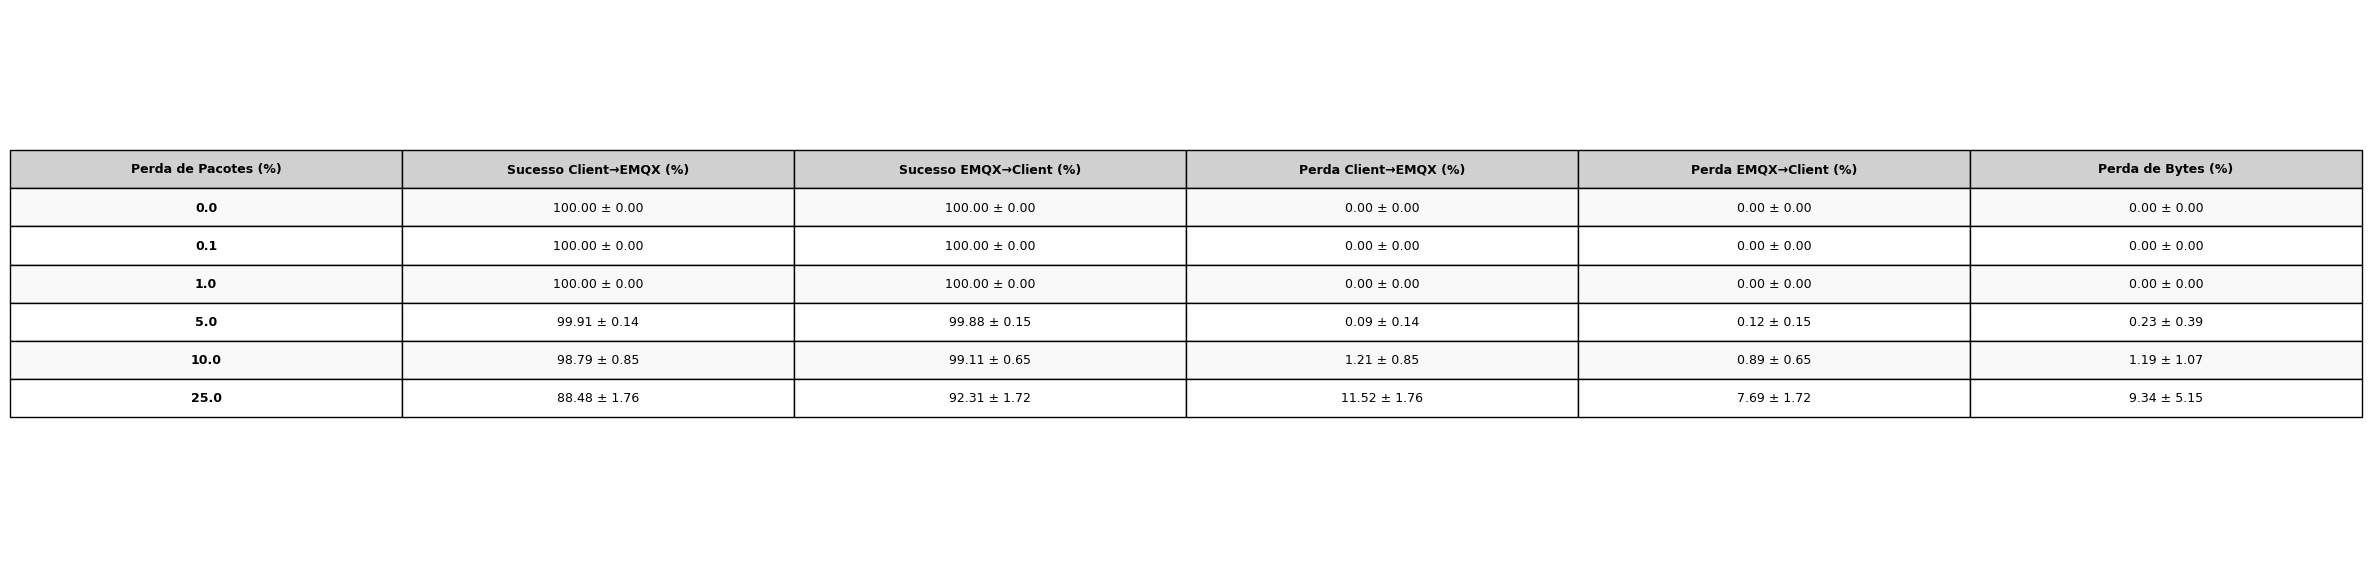

In [12]:
# ------------------ TABELA RESUMIDA ------------------

# Novo agrupamento para gerar porcentagens e métricas mais sintéticas
df['taxa_sucesso_client_emqx'] = df['Total_send_success_client_to_emqx'] / df['Total_Packets_Client']
df['taxa_sucesso_emqx_client'] = df['Total_send_success_emqx_to_client'] / df['Total_Packets_EMQX']
df['perda_client_emqx'] = df['Total_loss_client_emqx'] / df['Total_Packets_Client']
df['perda_emqx_client'] = df['Total_loss_emqx_client'] / df['Total_Packets_EMQX']
df['perda_bytes'] = (df['Total_bytes_client'] - df['Total_bytes_emqx']) / df['Total_bytes_client']

# Agrupando e formatando
resumo = df.groupby('Loss').agg({
    'taxa_sucesso_client_emqx': ['mean', 'std'],
    'taxa_sucesso_emqx_client': ['mean', 'std'],
    'perda_client_emqx': ['mean', 'std'],
    'perda_emqx_client': ['mean', 'std'],
    'perda_bytes': ['mean', 'std']
}).reset_index()

tabela_resumida = []
for idx, row in resumo.iterrows():
    tabela_resumida.append({
        'Perda de Pacotes (%)': float(row['Loss']),
        'Sucesso Client→EMQX (%)': f"{row[('taxa_sucesso_client_emqx', 'mean')]*100:.2f} ± {row[('taxa_sucesso_client_emqx', 'std')]*100:.2f}",
        'Sucesso EMQX→Client (%)': f"{row[('taxa_sucesso_emqx_client', 'mean')]*100:.2f} ± {row[('taxa_sucesso_emqx_client', 'std')]*100:.2f}",
        'Perda Client→EMQX (%)': f"{row[('perda_client_emqx', 'mean')]*100:.2f} ± {row[('perda_client_emqx', 'std')]*100:.2f}",
        'Perda EMQX→Client (%)': f"{row[('perda_emqx_client', 'mean')]*100:.2f} ± {row[('perda_emqx_client', 'std')]*100:.2f}",
        'Perda de Bytes (%)': f"{row[('perda_bytes', 'mean')]*100:.2f} ± {row[('perda_bytes', 'std')]*100:.2f}"
    })

tabela_resumida_df = pd.DataFrame(tabela_resumida)
tabela_resumida_df = tabela_resumida_df.sort_values(by='Perda de Pacotes (%)').reset_index(drop=True)

# Salva a imagem da tabela mais sintética
save_summary_table(tabela_resumida_df, 'tabela_quic_resumida.png')